# Example analysis notebook - single cell studies database

This notebook produces figures in the manuscript `A curated database reveals trends in single cell transcriptomics`

Notebook repository: https://github.com/vals/single-cell-studies/

The database is available at: https://www.nxn.se/single-cell-studies/

Running this notebook will save the following figures in the current folder:
```
all_studies.pdf
biorxiv_over_time.pdf
cells_per_month.pdf
clustering_over_time.pdf
clusters_per_cells.pdf
pseudotime_over_time.pdf
scrnaseq_studies.pdf
studies_over_time.pdf
techniques_over_time.pdf
tsne_over_time.pdf
```

In [1]:
# %pylab inline
# %config InlineBackend.figure_format = 'retina'

import io

import matplotlib.font_manager
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# Only pandas >= v0.25.0 supports column names with spaces in queries
import pandas as pd
ts = pd.Timestamp  # Alias for pd.Timestamp
import plotnine as p
import requests
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
import matplotlib.colors as mplcol
import colorsys

warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's

In [2]:
url = "http://nxn.se/single-cell-studies/data.tsv"
df = pd.read_csv(url, sep='\t')

# converts string to date format, can only be run once!
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# converts string of reported cells total to float, can only be run once!
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

print(df.shape)

(1035, 27)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


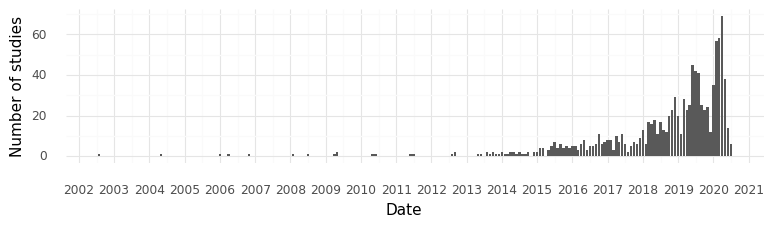

<ggplot: (8747085252798)>


In [3]:
# plot number of studies over time
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI'), data=df.resample('1M', on='Date').count()[['DOI']].reset_index())
    + p.geom_bar(stat='identity')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies')
)
fig.save('studies_over_time.pdf')
print(fig)

In [4]:
tdf = df.assign(Technique = df['Technique'].str.split(' & ')).explode('Technique')

# Technique dictionary for top 5 techniques
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}

t_dict

{'Chromium': 'Chromium',
 'Drop-seq': 'Drop-seq',
 'InDrops': 'InDrops',
 'SMARTer (C1)': 'SMARTer (C1)',
 'Smart-seq2': 'Smart-seq2'}

In [5]:
# Maps remaining techniques to 'Other'.
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))

# list of techniques in alphabetic order for the plot with 'Other' at the end.
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,

    )
)

In [7]:
def lightness(color, lightness):
    '''Proportionally modulate color.
    '''
    rgb = mplcol.colorConverter.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = lightness
    new_color = colorsys.hls_to_rgb(h, l, s)
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color


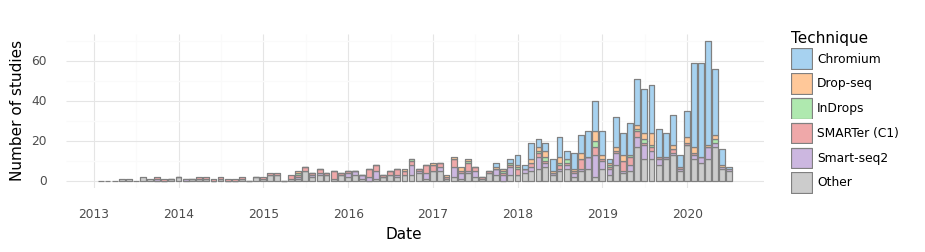

<ggplot: (-9223363289799617820)>

In [8]:
# Lighten matplotlib default colors
clrs = list(map(lambda c: lightness(c, 0.8), ['C0', 'C1', 'C2', 'C3', 'C4', 'grey']))

# Plot number of studies per month by technique
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Technique'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)
fig.save('techniques_over_time.pdf')
fig

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


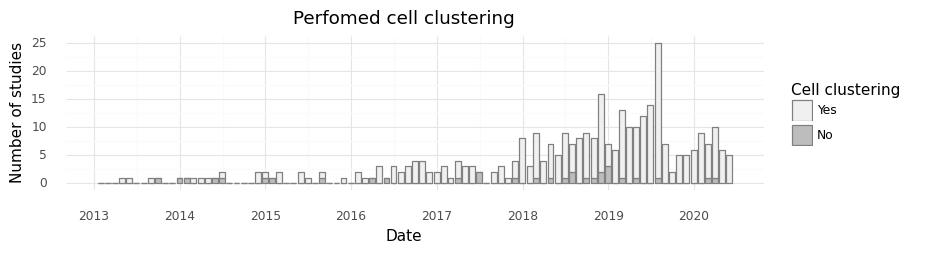

<ggplot: (8747055176077)>

In [9]:
# plot number of studies doing clustering over time

tdf = df[['Date', 'Cell clustering', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Cell clustering')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Cell clustering'] = (
    pd.Categorical(
        per_month['Cell clustering'],
        categories=['Yes', 'No'],
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Cell clustering'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed cell clustering')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('clustering_over_time.pdf')
fig

In [10]:
tdf['Cell clustering'].value_counts(normalize=True)

Yes    0.897361
No     0.102639
Name: Cell clustering, dtype: float64

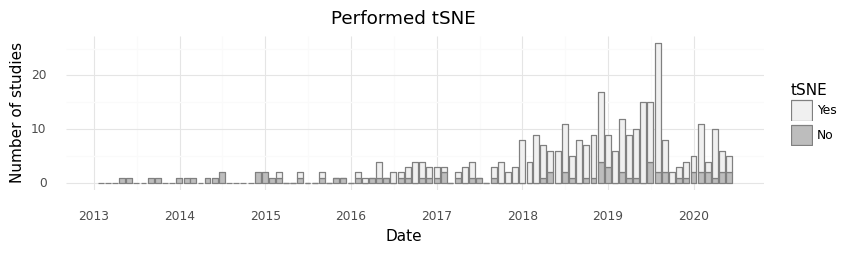

<ggplot: (-9223363289799778209)>

In [11]:
# plot number of studies using tsne over time

tdf = df[['Date', 'tSNE', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('tSNE')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['tSNE'] = (
    pd.Categorical(
        per_month['tSNE'],
        categories=['Yes', 'No'],
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='tSNE'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Performed tSNE')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('tsne_over_time.pdf')
fig

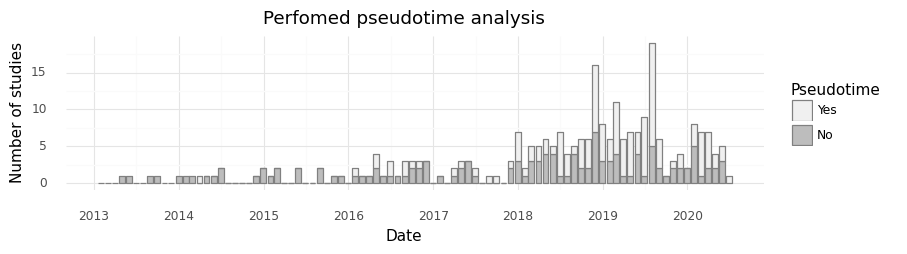

<ggplot: (-9223363289799888903)>

In [12]:
#plot number of studies performing pseudoanalysis over time

tdf = df[['Date', 'Pseudotime', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Pseudotime')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Pseudotime'] = (
    pd.Categorical(
        per_month['Pseudotime'],
        categories=['Yes', 'No']
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='Pseudotime'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed pseudotime analysis')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('pseudotime_over_time.pdf')
fig

In [16]:
tdf = df.assign(Authors = df['Authors'].str.split(', ')).explode('Authors')
cts_ = tdf.resample('1M', on='Date').count().index[1]

unique_authors = {}
for cts_ in tdf.resample('1M', on='Date').count().index:
    unique_authors[cts_] = tdf.query('Date < @cts_')[['Authors']].nunique()
    
unique_authors = pd.DataFrame(unique_authors).T.reset_index().rename(columns={'index': 'Date'})

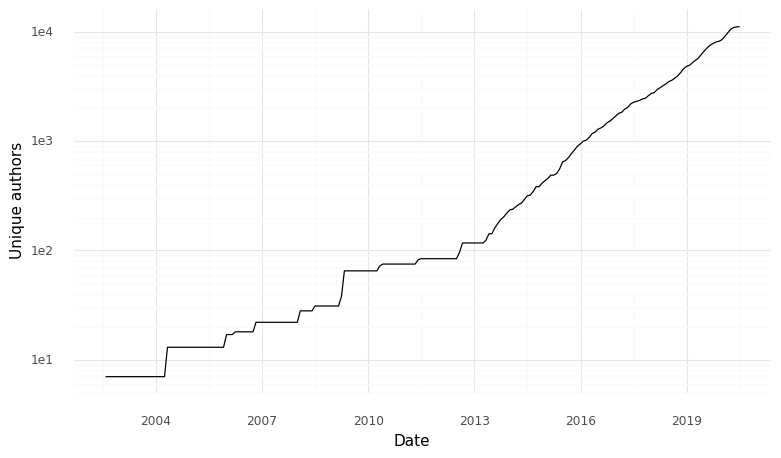

<ggplot: (-9223363289799740556)>

In [17]:
p.options.figure_size = (9, 5)
fig = (
    p.ggplot(p.aes(x='Date', y='Authors'), unique_authors)
    + p.geom_line()
    + p.scale_y_log10()
    + p.scale_x_datetime(
        breaks=date_breaks('3 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Unique authors')
    + p.theme_minimal(base_family='Arial')
)

fig.save('unique_authors.pdf')
fig

In [18]:
unique_authors['authors_pct_change'] = (
    unique_authors['Authors']
    .pct_change()
    .replace(0., np.nan)
)

doubling_time = (
    unique_authors
    .assign(year = unique_authors['Date'].dt.year)
    .groupby('year')
    .apply(lambda d: np.log(2) / np.log(1 + d['authors_pct_change'].mean()))
    .to_frame()
    .rename(columns={0: 'doubling_time'})
    .reset_index()
)

doubling_time

,year,doubling_time
0,2002,NaN
1,2003,NaN
2,2004,1.119715
3,2005,2.583825
4,2006,5.271610
5,2007,NaN
6,2008,3.985924
7,2009,1.805004
8,2010,9.624041
9,2011,12.119113


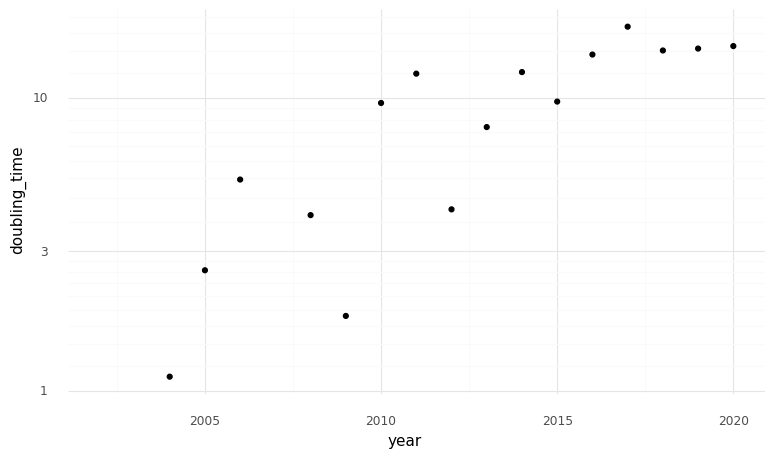

<ggplot: (8747054448823)>

In [19]:
p.options.figure_size = (9, 5)
(
    p.ggplot(p.aes(x='year', y='doubling_time'), doubling_time)
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
)

In [20]:
unique_authors['doubing_time'] = (
    (np.log(2) / np.log(1 + unique_authors['authors_pct_change']))
    .replace([np.inf, -np.inf], np.nan)
)

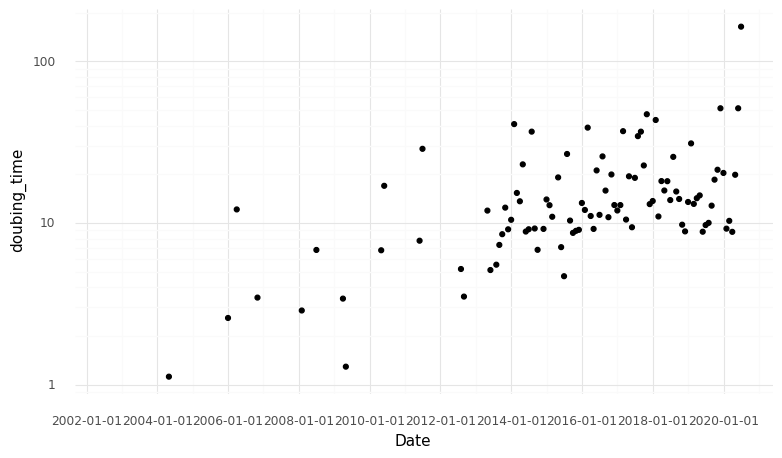

<ggplot: (-9223363289800382776)>

In [21]:
p.options.figure_size = (9, 5)
(
    p.ggplot(p.aes(x='Date', y='doubing_time'), unique_authors)
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
)

In [22]:
# Check top 7 journals.
top_journals = (
    df['Journal']
    .value_counts()
    .head(7)
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'Journal', 'Journal': 'Studies'})
)
top_journals

,Journal,Studies
0,bioRxiv,136
1,Nature,82
2,Cell,73
3,Nat Commun,71
4,Cell Reports,66
5,Science,48
6,Cell Stem Cell,28


In [23]:
# Check top 7 most common tissues.
tdf = df.assign(Tissue = df['Tissue'].str.split(' & ')).explode('Tissue')
top_tissues = (
    tdf['Tissue']
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'Tissue', 'Tissue': 'Studies'})
    .head(7)
)
top_tissues

,Tissue,Studies
0,Brain,171
1,Culture,107
2,Blood,35
3,Pancreas,33
4,Lung,32
5,Heart,25
6,Bone marrow,22


In [24]:
# Number of studies with preprints in the biorxiv.

df['did_bioRxiv'] = df['bioRxiv DOI'].fillna('?').map(lambda s: {'-': 'No', '?': 'Unknown'}.get(s, 'Yes'))
print(df['did_bioRxiv'].value_counts())
bx_fracs = df['did_bioRxiv'].value_counts()

print('Fraction of studies in biorxiv:', bx_fracs['Yes'] / bx_fracs.sum())

No         415
Unknown    366
Yes        254
Name: did_bioRxiv, dtype: int64
Fraction of studies in biorxiv: 0.24541062801932367


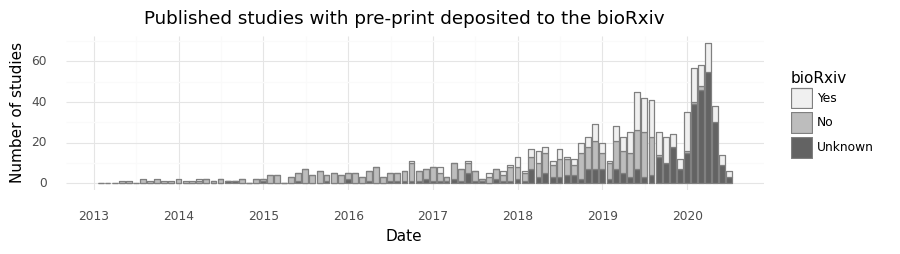

<ggplot: (8747054437054)>

In [25]:
# plot studies in the bioRxiv over time

tdf = df[['Date', 'did_bioRxiv', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('did_bioRxiv')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['did_bioRxiv'] = (
    pd.Categorical(
        per_month['did_bioRxiv'],
        categories=['Yes', 'No', 'Unknown'],
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='did_bioRxiv'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(
        y='Number of studies',
        title='Published studies with pre-print deposited to the bioRxiv',
        fill='bioRxiv'
    )
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('biorxiv_over_time.pdf')
fig

In [26]:
tdf = df.query('Date > @ts(20190101)')
tdf['did_bioRxiv'] = tdf['bioRxiv DOI'].fillna('?').map(lambda s: {'-': 'No', '?': 'Unknown'}.get(s, 'Yes'))
print(tdf['did_bioRxiv'].value_counts())
bx_fracs = tdf['did_bioRxiv'].value_counts()

print('Fraction of studies in biorxiv:', bx_fracs['Yes'] / bx_fracs.sum())

No         415
Unknown    365
Yes        254
Name: did_bioRxiv, dtype: int64
Fraction of studies in biorxiv: 0.24564796905222436


In [27]:
# display breakdown of deposited studies in biorXiv over the last 10 months 
display(
    per_month
    .pivot(index='Date', columns='did_bioRxiv', values='DOI')
    .fillna(0)
    .sort_index(ascending=False)
    .head(10)
)

did_bioRxiv,Yes,No,Unknown
Date,,,
2020-06-30,3.0,0.0,3.0
2020-05-31,5.0,0.0,9.0
2020-04-30,8.0,0.0,30.0
2020-03-31,14.0,0.0,55.0
2020-02-29,10.0,2.0,46.0
2020-01-31,17.0,1.0,39.0
2019-12-31,19.0,1.0,15.0
2019-11-30,5.0,0.0,7.0
2019-10-31,6.0,0.0,18.0


In [28]:
tdf = (
    df.assign(Measurement = df['Measurement'].str.split(' & '))
    .explode('Measurement')
    .dropna(subset=['Measurement'])
)

cats = tdf['Measurement'].value_counts().index

tdf['Measurement'] = (
    tdf['Measurement']
    .pipe(pd.Categorical, categories=cats)
)

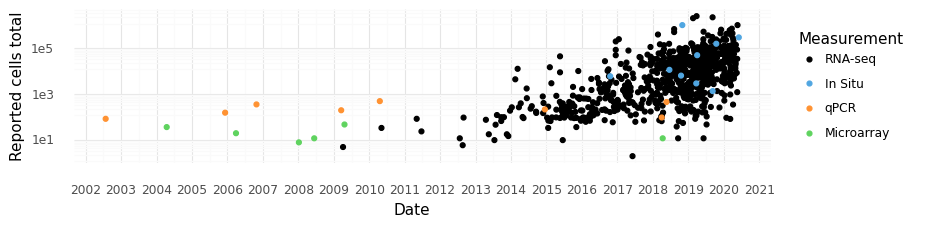

<ggplot: (8747054344354)>

In [29]:
# Plot kind of measurement over time vs number of cells reported.
m_idx = tdf['Measurement'].value_counts().index

clrs = list(map(lambda c: lightness(c, 0.6), ['C0', 'C1', 'C2', 'C3', 'C4']))

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='Reported cells total', color='Measurement'), 
        data=tdf.sort_values('Measurement')
    )
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.scale_color_manual(['k'] + clrs)
)
fig.save('all_studies.pdf')
fig

In [30]:
# Make list of techniques
df['Tech'] = df['Technique'].map(lambda s: t_dict.get(s, 'Other'))

techs = list(
    df['Tech']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

df['Tech'] = (
    pd.Categorical(
       df['Tech'],
        categories=techs
    )
)

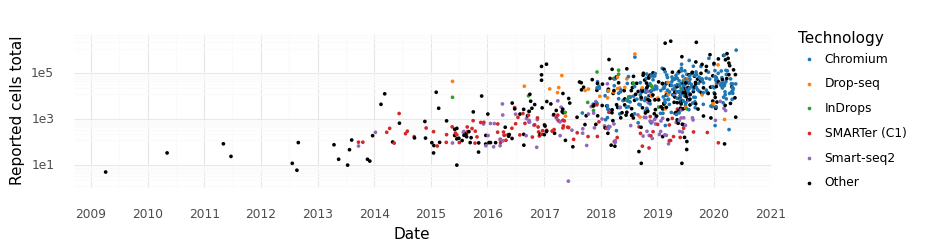

<ggplot: (-9223363289799731403)>

In [31]:
# plot reported number of cells vs technology used over time
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='Reported cells total', fill='Tech'),
        data=df.query('Measurement == "RNA-seq"')
    )
    + p.geom_point(alpha=1, color='none', size=1)
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.scale_fill_manual(['C0', 'C1', 'C2', 'C3', 'C4', 'black'])
    + p.labs(fill='Technology')
)
fig.save('scrnaseq_studies.pdf')
fig

In [32]:
# Display median cells per month for last 7 months.

cells_per_study = (
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')[['Reported cells total']]
    .median()
    .tail(8).iloc[:-1]
    .astype(int)
    .reset_index()
    .rename(columns={'Reported cells total': 'Median cells'})
)
cells_per_study

,Date,Median cells
0,2019-11-30,39895
1,2019-12-31,15601
2,2020-01-31,35173
3,2020-02-29,36044
4,2020-03-31,31514
5,2020-04-30,30396
6,2020-05-31,22000


In [33]:
# Display data for number of studies using RNA-seq for the last 10 months.

studies_per_month = (
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')
    .count()
    .tail(8)[['DOI']].iloc[:-1]
    .reset_index()
    .rename(columns={'DOI': 'Studies'})
)
studies_per_month

,Date,Studies
0,2019-11-30,12
1,2019-12-31,29
2,2020-01-31,57
3,2020-02-29,50
4,2020-03-31,68
5,2020-04-30,38
6,2020-05-31,13


In [34]:
monthly_stats = (
    studies_per_month
    .merge(cells_per_study)
    .assign(
        Month=studies_per_month['Date'].dt.strftime('%B %Y')
    )[['Month', 'Studies', 'Median cells']]
)

monthly_stats

,Month,Studies,Median cells
0,November 2019,12,39895
1,December 2019,29,15601
2,January 2020,57,35173
3,February 2020,50,36044
4,March 2020,68,31514
5,April 2020,38,30396
6,May 2020,13,22000


In [35]:
summary_table = pd.concat({
    'Monthly statistics': monthly_stats.T,
    'Top tissues': top_tissues.T,
    'Top journals': top_journals.T
}).T

summary_table.to_excel('Table 1.xlsx')
summary_table

Monthly statistics                       ... Top tissues    Top journals        
               Month Studies Median cells  ...     Studies         Journal Studies
0      November 2019      12        39895  ...         171         bioRxiv     136
1      December 2019      29        15601  ...         107          Nature      82
2       January 2020      57        35173  ...          35            Cell      73
3      February 2020      50        36044  ...          33      Nat Commun      71
4         March 2020      68        31514  ...          32    Cell Reports      66
5         April 2020      38        30396  ...          25         Science      48
6           May 2020      13        22000  ...          22  Cell Stem Cell      28

[7 rows x 7 columns]

In [36]:
df.shape

(1035, 29)

In [37]:
# Query median number of cells reported in 2019
df.query('Measurement == "RNA-seq" and Date > @ts("20190101T010101")').median()

Reported cells total                         17800.0
Number of reported cell types or clusters       13.0
dtype: float64

In [38]:
# Display median for last 7 months
df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().tail(8).iloc[:-1]

,Reported cells total,Number of reported cell types or clusters
Date,,
2019-11-30,39895.5,15.0
2019-12-31,15601.0,16.0
2020-01-31,35173.0,8.5
2020-02-29,36044.0,17.0
2020-03-31,31514.0,15.0
2020-04-30,30396.0,17.0
2020-05-31,22000.0,20.5


In [39]:
(
    df
    .query('Measurement == "RNA-seq" and Date > @ts("20200101T010101")')
    .resample('1M', on='Date')
    .sum()
    .tail(8)[['Reported cells total']].iloc[:-1]
    .median()
)

Reported cells total    1355585.0
dtype: float64

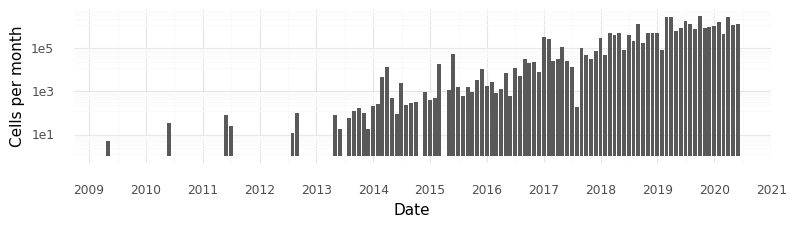

<ggplot: (8747051959609)>

In [40]:
# Plot total number of cells in studies published each month over time
rna_df = df.query('Measurement == "RNA-seq"').resample('M', on='Date').sum().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=rna_df.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Cells per month')
)
fig.save('cells_per_month.pdf')
fig

In [41]:
df.query('Date > @ts("20200101T010101")')['Reported cells total'].sum()

7739200.0

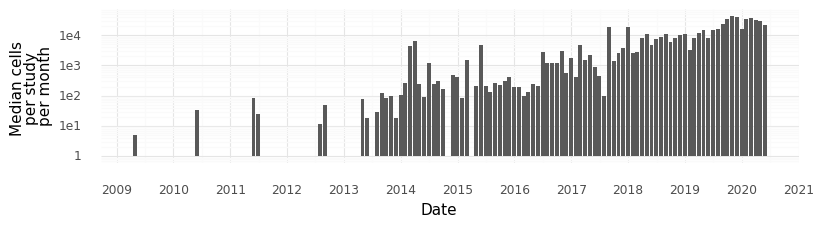

<ggplot: (8747055002716)>

In [42]:
# Plot median number of cells in studies each month
median_rna_df = df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=median_rna_df.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Median cells \nper study \nper month')
)
fig

In [43]:
# Take a look at the last 5 entries in the dataset (newest studies)
df.tail().T

,1030,1031,1032,1033,1034
Shorthand,Zhang et al bioRxiv,Niederriter Shami et al DCell,He et al bioRxiv,Le et al Immunity,Fischer et al
DOI,10.1101/2020.06.04.105700,10.1016/j.devcel.2020.05.010,10.1101/2020.06.14.150599,10.1016/j.immuni.2020.05.010,10.1038/s41467-020-16893-3
Authors,"Meng Zhang, Stephen W. Eichhorn, Brian Zingg, ...","Adrienne Niederriter Shami, Xianing Zheng, Sar...","Peng He, Brian A Williams, Diane Trout, Georgi...","Justin Le, Jeong Eun Park, Vi Luan Ha, Annie L...",NaN
Journal,bioRxiv,Developmental Cell,bioRxiv,Immunity,Nat Commun
Title,"Molecular, spatial and projection diversity of...","Single-Cell RNA Sequencing of Human, Macaque, ...",The changing mouse embryo transcriptome at who...,Single-Cell RNA-Seq Mapping of Human Thymopoie...,Post-surgical adhesions are triggered by calci...
Date,2020-06-05 00:00:00,2020-06-05 00:00:00,2020-06-15 00:00:00,2020-06-16 00:00:00,NaT
bioRxiv DOI,10.1101/2020.06.04.105700,NaN,10.1101/2020.06.14.150599,NaN,NaN
Reported cells total,300000,NaN,NaN,NaN,NaN
Organism,Mouse,"Human, Macaque, Mouse",Mouse,NaN,NaN
Tissue,Brain,Testes,NaN,NaN,NaN


In [44]:
df_ = df.query('Measurement == "RNA-seq"')

formula = 'Q("Number of reported cell types or clusters") ~ Q("Reported cells total")'

df_['data_scale'] = df_['Reported cells total'].pipe(np.log10).pipe(pd.qcut, 5)

def get_regression_coeff(d):
    c = (
        smf.ols(formula=formula, data=d)
        .fit()
        .params['Q("Reported cells total")']
    )
    
    return c

def predict_number_celltypes(d):
    fit = (
        smf.ols(formula=formula, data=d)
        .fit()
    )
    
    return d.assign(p_ = fit.predict(d))
    
df_ = df_.groupby('data_scale').apply(predict_number_celltypes)
df_.groupby('data_scale').apply(get_regression_coeff).pipe(np.reciprocal)

data_scale
(0.3, 2.606]        153.298134
(2.606, 3.441]      210.756797
(3.441, 4.063]     8100.666657
(4.063, 4.568]    13892.320871
(4.568, 6.402]     3333.339182
dtype: float64

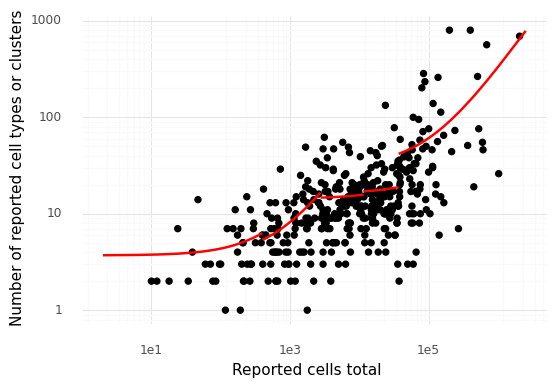

<ggplot: (8747054773105)>

In [45]:
# plot number of reported cell types/clusters vs total number of cells

p.options.figure_size = (6, 4)
fig = (
    p.ggplot(
        p.aes(
            x='Reported cells total',
            y='Number of reported cell types or clusters',
            group='data_scale'
        ),
        data=df_
    )
    + p.geom_point(alpha=1, size=2)
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.geom_line(p.aes(y='p_'), color='r', size=1)
    + p.labs(color='Technology')
    + p.theme_minimal(base_family='Arial')
)
fig.save('clusters_per_cells.pdf')
fig

In [46]:
tdf = df.assign(Tissue = df['Tissue'].str.split(', ')).explode('Tissue')

t_dict = {k: k for k in tdf.query('Tissue not in ["Culture", "Tumor", "Embryo"]')['Tissue'].value_counts().head(11).index}

tdf['Tissue_'] = tdf['Tissue'].map(lambda s: t_dict.get(s, 'Other'))

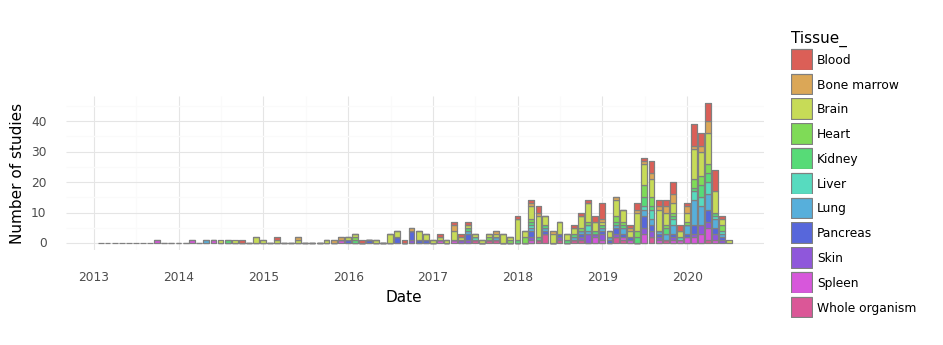

<ggplot: (-9223363289800396572)>

In [47]:
per_month = (
    tdf
    .groupby('Tissue_')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
    .query('Tissue_ != "Other"')
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Tissue_'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
)

fig

In [48]:
tdf = df.copy()

exclude_tissues = ["Culture", "Tumor", "Embryo", "Whole organism", "Organoid"]
t_dict = {k: k for k in tdf.query('Tissue not in @exclude_tissues')['Tissue'].value_counts().head(11).index}

tdf['Tissue_'] = tdf['Tissue'].map(lambda s: t_dict.get(s, 'Other'))

tdf['Tissue_'].value_counts()

Other          638
Brain          171
Blood           35
Pancreas        33
Lung            32
Heart           25
Bone marrow     22
Skin            19
Kidney          19
Spleen          18
Testis          12
Eye             11
Name: Tissue_, dtype: int64

In [49]:
t_ = pd.Categorical(tdf['Tissue_'])
idx = tdf['Tissue_'].value_counts().index.drop('Other').append(pd.Index(['Other']))
tdf['Tissue_'] = pd.Categorical(tdf['Tissue_'], categories=idx)

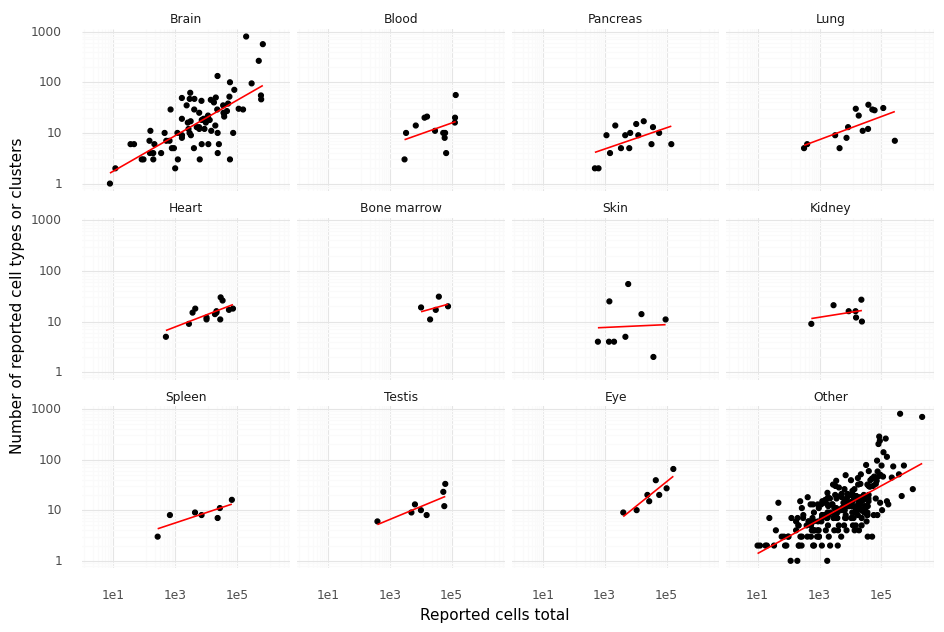

<ggplot: (8747055166244)>

In [50]:
p.options.figure_size = (11, 7)

fig = (
    p.ggplot(p.aes(x='Reported cells total', y='Number of reported cell types or clusters'), tdf)
    + p.geom_point()
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.stat_smooth(method='lm', se=False, color='red', size=0.66)
    + p.facet_wrap('~Tissue_', ncol=4)
)
fig.save('clusters_per_cells_by_tissue.pdf')
fig

In [51]:
formula = formula = 'np.log(Q("Number of reported cell types or clusters")) ~ np.log(Q("Reported cells total"))'

def get_coeff_pval(d):
    c = (
        smf.ols(formula=formula, data=d)
        .fit()
        .pvalues['np.log(Q("Reported cells total"))']
    )
    
    return c

tdf.groupby('Tissue_').apply(get_coeff_pval) < 0.05

Tissue_
Brain           True
Blood          False
Pancreas        True
Lung            True
Heart           True
Bone marrow    False
Skin           False
Kidney         False
Spleen          True
Testis          True
Eye             True
Other           True
dtype: bool